# Walmart Retail Sales Exploratory Analysis

Exploratory notebook for the Walmart weekly sales dataset used throughout the forecasting portfolio.

## Objectives

- Resolve project paths so the notebook works from the repo root or the project folder.
- Load the raw Walmart sales data and inspect its schema and data quality.
- Generate exploratory visualisations for overall, per-store, and seasonal behaviour.
- Preview the static feature engineering pipeline that powers the training workflow.
- Persist an enriched feature table into `data/processed/` for downstream experimentation.

In [33]:
from __future__ import annotations

import math
from pathlib import Path
from typing import Final

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate
from omegaconf import OmegaConf

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (12, 6), "axes.titlesize": 14, "axes.labelsize": 12})

def resolve_project_dir(project_name: str = "retail_sales_walmart") -> Path:
    """Locate the Walmart project directory regardless of launch location."""
    cwd = Path.cwd().resolve()

    # Common entry points: repo root, project folder, notebooks folder
    if (cwd / "projects" / project_name).exists():
        return cwd / "projects" / project_name

    if cwd.name == project_name and (cwd / "data").exists():
        return cwd

    if cwd.name == "notebooks" and (cwd.parent / "data").exists():
        return cwd.parent

    for parent in cwd.parents:
        if (parent / "projects" / project_name).exists():
            return parent / "projects" / project_name
        if parent.name == project_name and (parent / "data").exists():
            return parent

    raise FileNotFoundError(
        "Unable to locate project directory. Run from the repo root or ensure the "
        "current working directory contains the retail_sales_walmart project."
    )

PROJECT_DIR: Final[Path] = resolve_project_dir()
DATA_DIR: Final[Path] = PROJECT_DIR / "data"
RAW_PATH: Final[Path] = DATA_DIR / "raw" / "Walmart.csv"
PROCESSED_DIR: Final[Path] = DATA_DIR / "processed"
FEATURE_CACHE: Final[Path] = PROCESSED_DIR / "walmart_features_exploratory.parquet"
CONF_DIR: Final[Path] = PROJECT_DIR.parents[1] / "src" / "ml_portfolio" / "conf"
FEATURE_CONFIG_NAME: Final[str] = "walmart_full"
FEATURE_CONFIG_PATH: Final[Path] = CONF_DIR / "feature_engineering" / f"{FEATURE_CONFIG_NAME}.yaml"

print(f"Project directory: {PROJECT_DIR}")
print(f"Raw data path: {RAW_PATH}")
print(f"Feature config: {FEATURE_CONFIG_PATH}")

Project directory: C:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart
Raw data path: C:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\data\raw\Walmart.csv
Feature config: C:\Users\mvill\github\forecasting_demo\src\ml_portfolio\conf\feature_engineering\walmart_full.yaml


## 1. Load and inspect the raw dataset

In [34]:
df_raw = pd.read_csv(RAW_PATH)
row_count, col_count = df_raw.shape
print(f"Rows: {row_count:,} | Columns: {col_count}")
df_raw.head()

Rows: 6,435 | Columns: 8


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### Data quality overview
We compute summary statistics, missing-value counts, and duplicate checks over the canonical Store-Date key.

In [35]:
display(df_raw.describe(include="all").transpose())
missing_summary = (
    df_raw.isna().sum().rename("missing_count").to_frame()
    .assign(missing_pct=lambda d: (d["missing_count"] / row_count) * 100)
)
display(missing_summary.sort_values("missing_pct", ascending=False))
duplicate_rows = df_raw.duplicated(subset=["Store", "Date"]).sum()
print(f"Duplicate [Store, Date] pairs: {duplicate_rows}")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,6435.0,NaN,NaN,NaN,23.0,12.988182,1.0,12.0,23.0,34.0,45.0
Date,6435,143,05-02-2010,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekly_Sales,6435.0,NaN,NaN,NaN,1046964.877562,564366.622054,209986.25,553350.105,960746.04,1420158.66,3818686.45
Holiday_Flag,6435.0,NaN,NaN,NaN,0.06993,0.255049,0.0,0.0,0.0,0.0,1.0
Temperature,6435.0,NaN,NaN,NaN,60.663782,18.444933,-2.06,47.46,62.67,74.94,100.14
Fuel_Price,6435.0,NaN,NaN,NaN,3.358607,0.45902,2.472,2.933,3.445,3.735,4.468
CPI,6435.0,NaN,NaN,NaN,171.578394,39.356712,126.064,131.735,182.616521,212.743293,227.232807
Unemployment,6435.0,NaN,NaN,NaN,7.999151,1.875885,3.879,6.891,7.874,8.622,14.313


,missing_count,missing_pct
Store,0,0.0
Date,0,0.0
Weekly_Sales,0,0.0
Holiday_Flag,0,0.0
Temperature,0,0.0
Fuel_Price,0,0.0
CPI,0,0.0
Unemployment,0,0.0


Duplicate [Store, Date] pairs: 0


## 2. Seasonal and store-level behaviour

,mean,median,std,max
Store,,,,
20,2.107677e+06,2053165.41,275900.562742,3766687.43
4,2.094713e+06,2073951.38,266201.442297,3676388.98
14,2.020978e+06,2004330.30,317569.949476,3818686.45
13,2.003620e+06,1958823.56,265506.995776,3595903.20
2,1.925751e+06,1879107.31,237683.694682,3436007.68
10,1.899425e+06,1827521.71,302262.062504,3749057.69
27,1.775216e+06,1731935.43,239930.135688,3078162.08
6,1.564728e+06,1524390.07,212525.855862,2727575.18
1,1.555264e+06,1534849.64,155980.767761,2387950.20


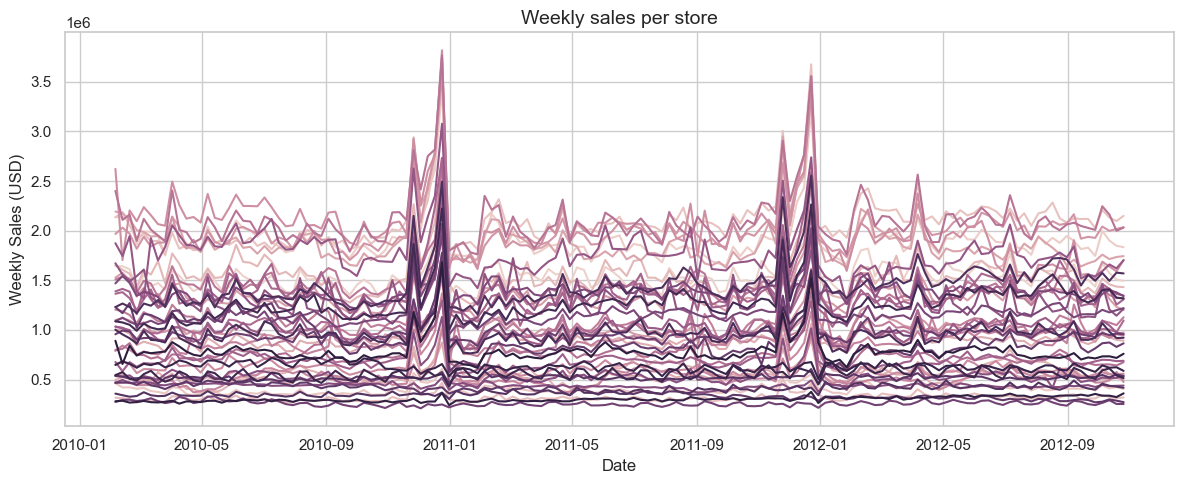

In [36]:
df = df_raw.copy()
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df.sort_values(["Store", "Date"], inplace=True)
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Quarter"] = df["Date"].dt.quarter
df["DayOfYear"] = df["Date"].dt.dayofyear

df["Week_sin"] = np.sin(2 * math.pi * df["Week"] / 52)
df["Week_cos"] = np.cos(2 * math.pi * df["Week"] / 52)
df["Month_sin"] = np.sin(2 * math.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * math.pi * df["Month"] / 12)

store_summary = (
    df.groupby("Store")["Weekly_Sales"]
    .agg(["mean", "median", "std", "max"])
    .sort_values("mean", ascending=False)
)
display(store_summary.head(10))
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="Date", y="Weekly_Sales", hue="Store", legend=False)
plt.title("Weekly sales per store")
plt.ylabel("Weekly Sales (USD)")
plt.tight_layout()

### Holiday effect snapshot

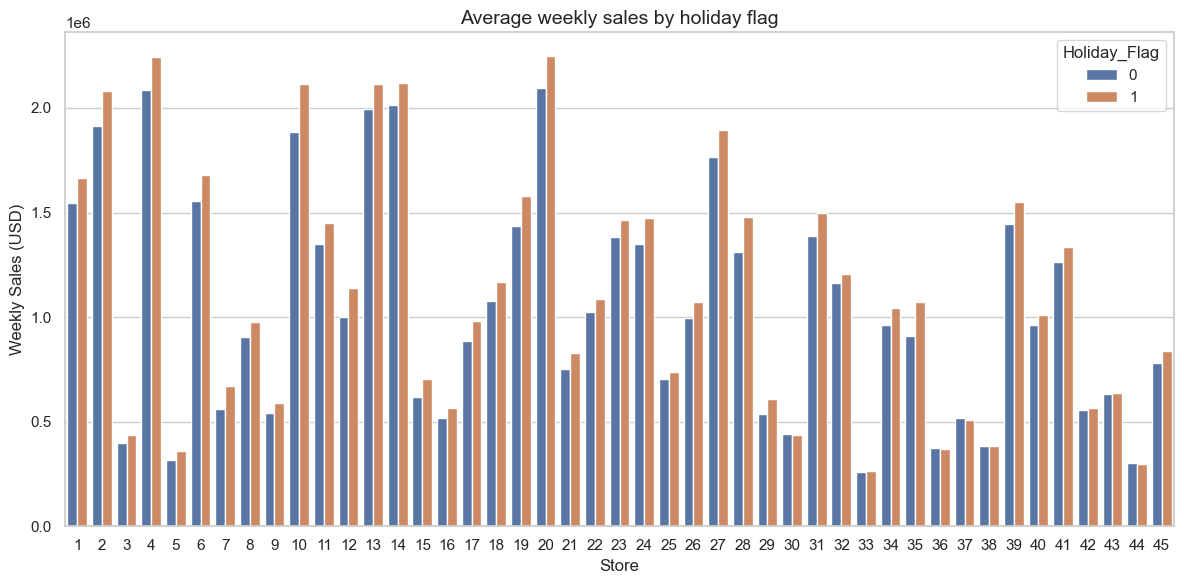

In [37]:
holiday_totals = (
    df.groupby(["Holiday_Flag", "Store"])
    ["Weekly_Sales"]
    .mean()
    .reset_index()
)
sns.barplot(data=holiday_totals, x="Store", y="Weekly_Sales", hue="Holiday_Flag")
plt.title("Average weekly sales by holiday flag")
plt.ylabel("Weekly Sales (USD)")
plt.tight_layout()

## 3. Reusing the Hydra static feature pipeline
The training script relies on `feature_engineering/walmart_full.yaml`. We can instantiate that static pipeline here to ensure parity between exploration and modelling.

In [38]:
feature_cfg = OmegaConf.load(FEATURE_CONFIG_PATH)
static_cfg = feature_cfg.get("static")
static_pipeline = instantiate(static_cfg)
features_df = static_pipeline.engineer_features(df_raw.copy())
features_df["Date"] = pd.to_datetime(features_df["Date"], dayfirst=True, format="mixed")
features_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,...,Weekly_Sales_rolling_mean_52_Store,Weekly_Sales_rolling_std_52_Store,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,week_sin,week_cos
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,...,0.000000e+00,0.000000,0.866025,5.000000e-01,-2.449294e-16,1.0,1.0,6.123234e-17,0.568065,0.822984
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,...,1.643691e+06,0.000000,0.866025,5.000000e-01,-2.449294e-16,1.0,1.0,6.123234e-17,0.663123,0.748511
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,...,1.642824e+06,1225.741321,0.866025,5.000000e-01,-2.449294e-16,1.0,1.0,6.123234e-17,0.748511,0.663123
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,...,1.632539e+06,17835.791719,0.866025,5.000000e-01,-2.449294e-16,1.0,1.0,6.123234e-17,0.822984,0.568065
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,...,1.576836e+06,112353.415114,1.000000,6.123234e-17,-2.449294e-16,1.0,1.0,6.123234e-17,0.885456,0.464723


### Feature importance proxy
A quick tree-based model gives a sense of which engineered signals matter most on a single store sample.

,importance
Weekly_Sales_lag_52_Store,0.332617
week,0.180319
day,0.077959
Weekly_Sales_lag_4_Store,0.058418
Weekly_Sales_lag_26_Store,0.035623
Weekly_Sales_lag_8_Store,0.029925
Weekly_Sales_lag_1_Store,0.029277
Weekly_Sales_rolling_mean_13_Store,0.029208
Weekly_Sales_lag_13_Store,0.029171
Weekly_Sales_lag_2_Store,0.022971


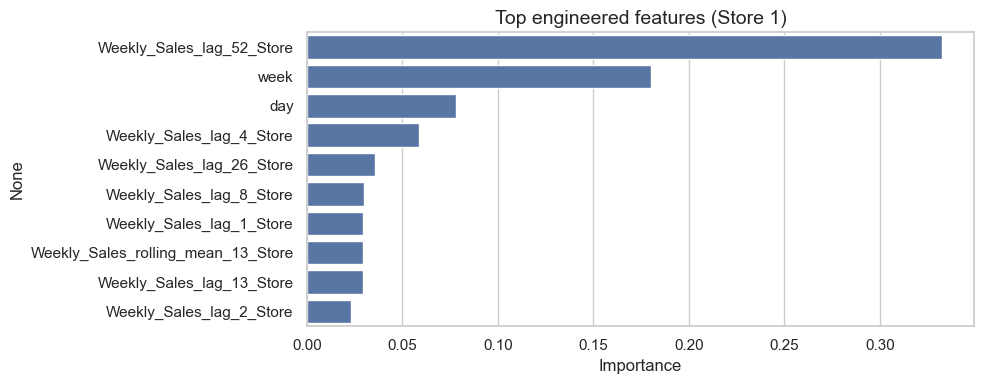

In [39]:
store_example = features_df[features_df["Store"] == 1].sort_values("Date")
feature_cols = [col for col in store_example.columns if col not in ["Weekly_Sales", "Date", "Store"]]
X = store_example[feature_cols].astype(float).values
y = store_example["Weekly_Sales"].values
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=importances.values, y=importances.index, orient="h")
plt.title("Top engineered features (Store 1)")
plt.xlabel("Importance")
plt.tight_layout()
importances.to_frame(name="importance")

## 4. Persist enriched features
Cache the engineered table so training notebooks or scripts can reuse the same features without recomputation.

In [40]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
features_df.to_parquet(FEATURE_CACHE, index=False)
print(f"Feature table saved to {FEATURE_CACHE}")

Feature table saved to C:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\data\processed\walmart_features_exploratory.parquet
